<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/JB_PJ_Time_series_3_Monthly_Sales_of_champagne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# evaluate the finalized model on the validation dataset
import warnings
import itertools
import pandas as pd
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import Grouper
from pandas import Series
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AR

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import exp
from math import log

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Problem Description

The problem is to predict the number of monthly sales of champagne for the Perrin Freres label
(named for a region in France). The dataset provides the number of monthly sales of champagne
from January 1964 to September 1972, or just under 10 years of data. The values are a count
of millions of sales and there are 105 observations. The dataset is credited to Makridakis and
Wheelwright, 1989. Below is a sample of the first few rows of the dataset.

In [ ]:
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
series

Dataset 93, Validation 12


Month
1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
              ... 
1972-05-01    4618
1972-06-01    5312
1972-07-01    4298
1972-08-01    1413
1972-09-01    5877
Name: Sales, Length: 105, dtype: int64

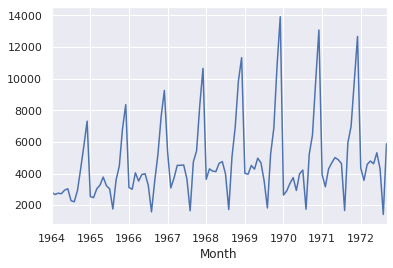

In [ ]:
series.plot()

 dataset.csv: Observations from January 1964 to September 1971 (93 observations).

 validation.csv: Observations from October 1971 to September 1972 (12 observations).

# Persistence

In [ ]:
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
# predict
  yhat = history[-1]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
  

>Predicted=4121.000, Expected=4647
>Predicted=4647.000, Expected=4753
>Predicted=4753.000, Expected=3965
>Predicted=3965.000, Expected=1723
>Predicted=1723.000, Expected=5048
>Predicted=5048.000, Expected=6922
>Predicted=6922.000, Expected=9858
>Predicted=9858.000, Expected=11331
>Predicted=11331.000, Expected=4016
>Predicted=4016.000, Expected=3957
>Predicted=3957.000, Expected=4510
>Predicted=4510.000, Expected=4276
>Predicted=4276.000, Expected=4968
>Predicted=4968.000, Expected=4677
>Predicted=4677.000, Expected=3523
>Predicted=3523.000, Expected=1821
>Predicted=1821.000, Expected=5222
>Predicted=5222.000, Expected=6872
>Predicted=6872.000, Expected=10803
>Predicted=10803.000, Expected=13916
>Predicted=13916.000, Expected=2639
>Predicted=2639.000, Expected=2899
>Predicted=2899.000, Expected=3370
>Predicted=3370.000, Expected=3740
>Predicted=3740.000, Expected=2927
>Predicted=2927.000, Expected=3986
>Predicted=3986.000, Expected=4217
>Predicted=4217.000, Expected=1738
>Predicted=173

# Data Analysis

In [ ]:
print(series.describe())

count      105.000000
mean      4761.152381
std       2553.502601
min       1413.000000
25%       3113.000000
50%       4217.000000
75%       5221.000000
max      13916.000000
Name: Sales, dtype: float64


 The number of observations (count) matches our expectation, meaning we are handling
the data correctly.

 The mean is about 4,641, which we might consider our level in this series.

 The standard deviation (average spread from the mean) is relatively large at 2,486 sales.

 The percentiles along with the standard deviation do suggest a large spread to the data

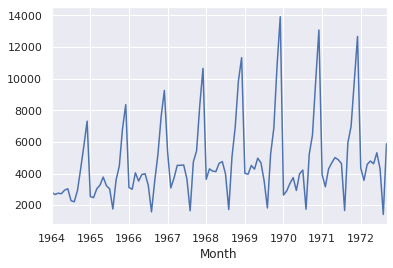

In [ ]:
series.plot()
pyplot.show()

 There may be an increasing trend of sales over time.

 There appears to be systematic seasonality to the sales for each year.

 The seasonal signal appears to be growing over time, suggesting a multiplicative relationship
(increasing change).

 There do not appear to be any obvious outliers.

 The seasonality suggests that the series is almost certainly non-stationary

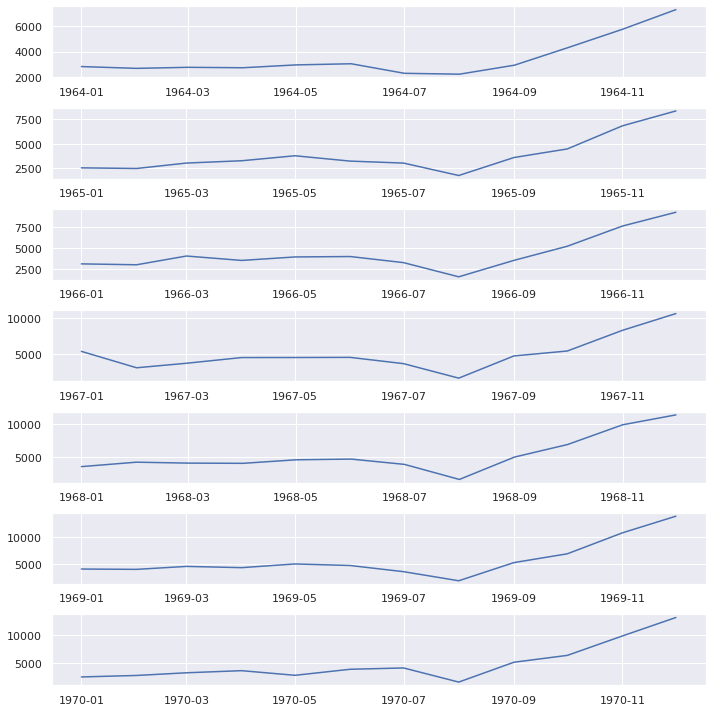

In [ ]:
groups = series['1964':'1970'].groupby(Grouper(freq='A'))
years = DataFrame()
pyplot.figure(figsize=(10,10))
i = 1
n_groups = len(groups)
for name, group in groups:
  pyplot.subplot((n_groups*100) + 10 + i)
  i += 1
  pyplot.plot(group)
pyplot.tight_layout()
pyplot.show()

Running the example creates the stack of 7 line plots. We can clearly see a dip each August
and a rise from each August to December. This pattern appears the same each year, although
at different levels. This will help with any explicitly season-based modeling later.

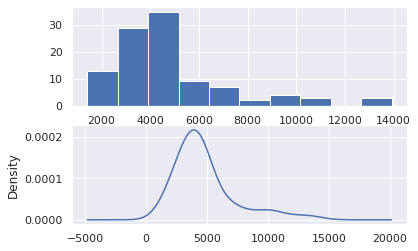

In [ ]:
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

 The distribution is not Gaussian.

 The shape has a long right tail and may suggest an exponential distribution

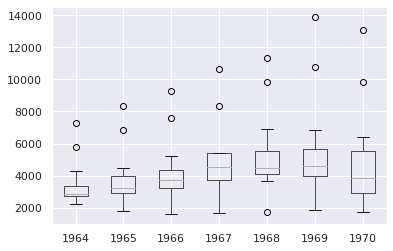

In [ ]:
groups = series['1964':'1970'].groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
  years[name.year] = group.values
years.boxplot()
pyplot.show()

 The median values for each year (red line) may show an increasing trend.

 The spread or middle 50% of the data (blue boxes) does appear reasonably stable.

 There are outliers each year (black crosses); these may be the tops or bottoms of the
seasonal cycle.

 The last year, 1970, does look different from the trend in prior years

# ARIMA Models

# Manually Configured ARIMA

In [ ]:
# create a differenced time series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return Series(diff)

ADF Statistic: -7.134898
p-value: 0.000000
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586


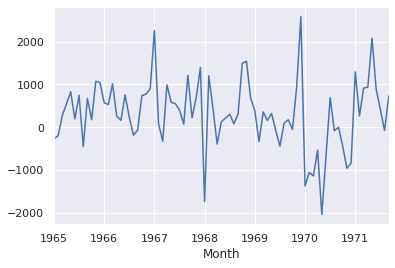

In [ ]:
# difference data
series=dataset
X = series.values
X = X.astype('float32')

# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]

# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
# plot differenced data
stationary.plot()
pyplot.show()

Running the example outputs the result of a statistical significance test of whether the
differenced series is stationary. Specifically, the augmented Dickey-Fuller test. The results show
that the test statistic value -7.134898 is smaller than the critical value at 1% of -3.515. This
suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a
low probability that the result is a statistical fluke). Rejecting the null hypothesis means that
the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure

A plot of the differenced dataset is also created. The plot does not show any obvious
seasonality or trend, suggesting the seasonally differenced dataset is a good starting point for
modeling. We will use this dataset as an input to the ARIMA model. It also suggests that no
further differencing may be required, and that the d parameter may be set to 0.

In [ ]:
series

Month
1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
              ... 
1971-05-01    5010
1971-06-01    4874
1971-07-01    4633
1971-08-01    1659
1971-09-01    5951
Name: Sales, Length: 93, dtype: int64

In [ ]:
stationary

Month
1965-01-01    -274.0
1965-02-01    -197.0
1965-03-01     276.0
1965-04-01     545.0
1965-05-01     830.0
               ...  
1971-05-01    2083.0
1971-06-01     888.0
1971-07-01     416.0
1971-08-01     -79.0
1971-09-01     730.0
Length: 81, dtype: float64

For reference, the seasonal difference operation can be inverted by adding the observation
for the same month the year before. This is needed in the case that predictions are made by a
model fit on seasonally differenced data. The function to invert the seasonal difference operation
is listed below for completeness.

In [ ]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

The next first step is to select the lag values for the Autoregression (AR) and Moving
Average (MA) parameters, p and q respectively. We can do this by reviewing Autocorrelation
Function (ACF) and Partial Autocorrelation Function (PACF) plots. Note, we are now using
the seasonally differenced stationary.csv as our dataset. This is because the manual seasonal
differencing performed is different from the lag=1 differencing performed by the ARIMA model
with the d parameter. The example below creates ACF and PACF plots for the series

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


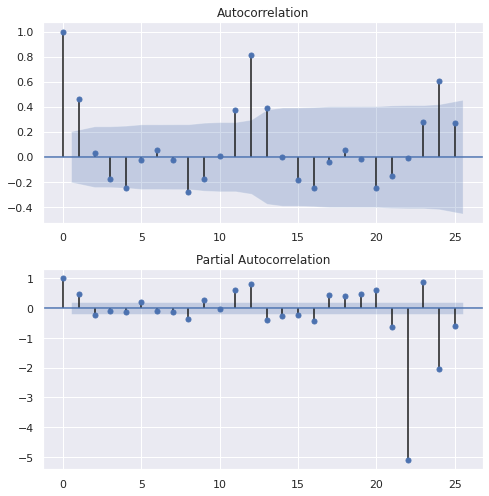

In [ ]:
pyplot.figure(figsize=(7,7))
pyplot.subplot(211)
plot_acf(series, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, lags=25, ax=pyplot.gca())
pyplot.tight_layout()
pyplot.show()

 The ACF shows a significant lag for 1 month.

 The PACF shows a significant lag for 1 month, with perhaps some significant lag at 12
and 13 months.

 Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of
AR and MA.

A good starting point for the p and q values is also 1. The PACF plot also suggests that
there is still some seasonality present in the differenced data. We may consider a better model
of seasonality, such as modeling it directly and explicitly removing it from the model rather
than seasonal differencing.

This quick analysis suggests an ARIMA(1,0,1) on the stationary data may be a good starting
point. The historic observations will be seasonally differenced prior to the fitting of each
ARIMA model. The differencing will be inverted for all predictions made to make them directly
comparable to the expected observation in the original sale count units. Experimentation shows
that this configuration of ARIMA does not converge and results in errors by the underlying library. Further experimentation showed that adding one level of differencing to the stationary
data made the model more stable. The model can be extended to ARIMA(1,1,1).
We will also disable the automatic addition of a trend constant from the model by setting
the trend argument to nc for no constant in the call to fit(). From experimentation, I find
that this can result in better forecast performance on some problems. The example below
demonstrates the performance of this ARIMA model on the test harness.

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff
# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

In [ ]:
# load data
series = dataset
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)
  # predict
  model = ARIMA(diff, order=(1,1,1))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = model_fit.forecast()[0]
  yhat = inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=8089.810, Expected=8314.000
>Predicted=9742.753, Expected=10651.000
>Predicted=5986.917, Expected=3633.000
>Predicted=3886.987, Expected=4292.000
>Predicted=4038.100, Expected=4154.000
>Predicted=4992.337, Expected=4121.000
>Predicted=5156.549, Expected=4647.000
>Predicted=5046.653, Expected=4753.000
>Predicted=4143.826, Expected=3965.000
>Predicted=2102.950, Expected=1723.000
>Predicted=5228.333, Expected=5048.000
>Predicted=5873.398, Expected=6922.000
>Predicted=8571.280, Expected=9858.000
>Predicted=11006.125, Expected=11331.000
>Predicted=4087.474, Expected=4016.000
>Predicted=4771.841, Expected=3957.000
>Predicted=4676.086, Expected=4510.000
>Predicted=4583.382, Expected=4276.000
>Predicted=5117.342, Expected=4968.000
>Predicted=5208.150, Expected=4677.000
>Predicted=4436.447, Expected=3523.000
>Predicted=2180.952, Expected=1821.000
>Predicted=5471.222, Expected=5222.000
>Predicted=7337.594, Expected=6872.000
>Predicted=10268.392, Expected=10803.000
>Predicted=11725.336

Running this example results in an RMSE of 956.942, which is dramatically
better than the persistence RMSE of 3186.501.

# Grid Search ARIMA Hyperparameters

 p: 0 to 6.

 d: 0 to 2.

 q: 0 to 6.

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff
# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
  X = X.astype('float32')
  train_size = int(len(X) * 0.50)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for t in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    model = ARIMA(diff, order=arima_order)
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
          continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
# load dataset
series = dataset
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=939.464
ARIMA(0, 0, 2) RMSE=962.289
ARIMA(0, 0, 3) RMSE=944.237
ARIMA(0, 0, 4) RMSE=958.787
ARIMA(0, 0, 5) RMSE=986.836
ARIMA(0, 0, 6) RMSE=1087.011
ARIMA(0, 1, 1) RMSE=958.297
ARIMA(0, 2, 1) RMSE=1146.987
ARIMA(1, 0, 0) RMSE=944.449
ARIMA(1, 1, 0) RMSE=1070.204
ARIMA(1, 1, 1) RMSE=956.955
ARIMA(1, 2, 0) RMSE=1555.858
ARIMA(2, 0, 0) RMSE=955.134
ARIMA(2, 0, 1) RMSE=948.649
ARIMA(2, 1, 0) RMSE=1030.467
ARIMA(2, 1, 1) RMSE=980.959
ARIMA(2, 2, 0) RMSE=1346.598
ARIMA(2, 2, 1) RMSE=1039.648
ARIMA(3, 0, 0) RMSE=959.165
ARIMA(3, 1, 0) RMSE=1028.226
ARIMA(3, 1, 1) RMSE=979.939
ARIMA(3, 2, 0) RMSE=1244.847
ARIMA(4, 0, 0) RMSE=968.411
ARIMA(4, 1, 0) RMSE=1046.524
ARIMA(4, 1, 1) RMSE=1006.257
ARIMA(4, 2, 0) RMSE=1227.555
ARIMA(4, 2, 1) RMSE=1055.487
ARIMA(5, 0, 0) RMSE=987.690
ARIMA(5, 1, 0) RMSE=1042.642
ARIMA(5, 2, 1) RMSE=1053.722
ARIMA(6, 0, 0) RMSE=996.466
ARIMA(6, 0, 1) RMSE=1062.907
Best ARIMA(0, 0, 1) RMSE=939.464


Running the example runs through all combinations and reports the results on those that
converge without error. The example takes a little over 2 minutes to run on modern hardware.
The results show that the best configuration discovered was ARIMA(0,0,1) with an RMSE of
939.464, slightly lower than the manually configured ARIMA from the previous section. This
difference may or may not be statistically significant.

We will select this ARIMA(0,0,1) model going forward

# Review Residual Errors

                 0
count    47.000000
mean    165.904742
std     934.696211
min   -2164.247449
25%    -289.651667
50%     191.759548
75%     732.992187
max    2367.304868


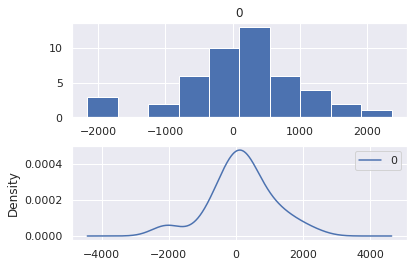

In [ ]:
# load data
series = dataset
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)
  # predict
  model = ARIMA(diff, order=(0,0,1))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = model_fit.forecast()[0]
  yhat = inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

Running the example first describes the distribution of the residuals. We can see that the
distribution has a right shift and that the mean is non-zero at 165.904728. This is perhaps a
sign that the predictions are biased.

The distribution of residual errors is also plotted. The graphs suggest a Gaussian-like
distribution with a bumpy left tail, providing further evidence that perhaps a power transform
might be worth exploring.

We could use this information to bias-correct predictions by adding the mean residual error
of 165.904728 to each forecast made. The example below performs this bias correlation.

# Correct with residual error

RMSE: 924.699
                 0
count    47.000000
mean      0.000014
std     934.696211
min   -2330.152177
25%    -455.556395
50%      25.854820
75%     567.087459
max    2201.400140


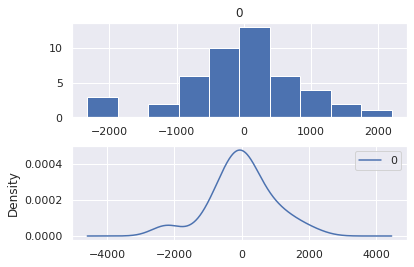

In [ ]:
# load data
series = dataset
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 165.904728
for i in range(len(test)):
  # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)
  # predict
  model = ARIMA(diff, order=(0,0,1))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = model_fit.forecast()[0]
  yhat = bias + inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  #print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

The performance of the predictions is improved very slightly from 939.464 to 924.699, which
may or may not be significant. The summary of the forecast residual errors shows that the
mean was indeed moved to a value very close to zero

# Check the time series of the residual errors for any type of autocorrelation.

It is also a good idea to check the time series of the residual errors for any type of autocorrelation. If present, it would suggest that the model has more opportunity to model the temporal
structure in the data. The example below re-calculates the residual errors and creates ACF and
PACF plots to check for any significant autocorrelation.

                 0
count    47.000000
mean    165.904742
std     934.696211
min   -2164.247449
25%    -289.651667
50%     191.759548
75%     732.992187
max    2367.304868


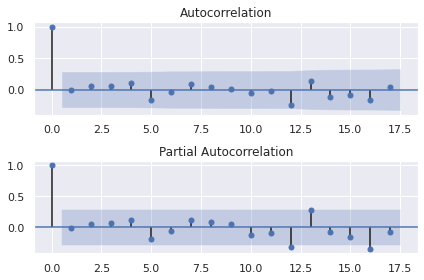

In [ ]:
# load data
series = dataset
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)
  # predict
  model = ARIMA(diff, order=(0,0,1))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = model_fit.forecast()[0]
  yhat = inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
pyplot.tight_layout()
pyplot.show()

The results suggest that what little autocorrelation is present in the time series has been
captured by the model.

# Model Validation

We can load the model and use it in a pretend operational manner. In the test harness section,
we saved the final 12 months of the original dataset in a separate file to validate the final model.
We can load this validation.csv file now and use it see how well our model really is on unseen
data. There are two ways we might proceed:

 Load the model and use it to forecast the next 12 months. The forecast beyond the first
one or two months will quickly start to degrade in skill.

 Load the model and use it in a rolling-forecast manner, updating the transform and model
for each time step. This is the preferred method as it is how one would use this model in
practice as it would achieve the best performance.

As with model evaluation in previous sections, we will make predictions in a rolling-forecast
manner. This means that we will step over lead times in the validation dataset and take the
observations as an update to the history.

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff
# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

Dataset 93, Validation 12
>Predicted=6794.773, Expected=6981.000
>Predicted=10101.763, Expected=9851.000
>Predicted=13219.067, Expected=12670.000
>Predicted=3996.535, Expected=4348.000
>Predicted=3465.934, Expected=3564.000
>Predicted=4522.683, Expected=4577.000
>Predicted=4901.336, Expected=4788.000
>Predicted=5190.094, Expected=4618.000
>Predicted=4930.190, Expected=5312.000
>Predicted=4944.785, Expected=4298.000
>Predicted=1699.409, Expected=1413.000
>Predicted=6085.324, Expected=5877.000
RMSE: 361.110


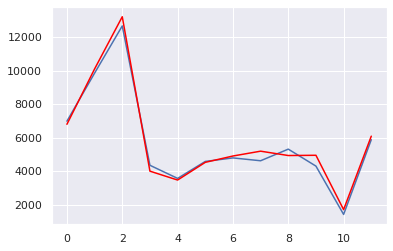

In [ ]:
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
diff = difference(X, months_in_year)

y = validation.values.astype('float32')
# fit model
model = ARIMA(diff, order=(0,0,1))
model_fit = model.fit(trend='nc', disp=0)

# bias constant, could be calculated from in-sample mean residual
bias = 165.904728

# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
  # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)
  # predict
  model = ARIMA(diff, order=(0,0,1))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = model_fit.forecast()[0]
  yhat = bias + inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)
  # observation
  obs = y[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

Running the example prints each prediction and expected value for the time steps in the
validation dataset. The final RMSE for the validation period is predicted at 361.110 million
sales. This is much better than the expectation of an error of a little more than 924 million
sales per month